In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
import keras.utils as image
import tensorflow as tf
from tensorflow.keras.models import save_model
import cv2 
from sklearn.model_selection import train_test_split
#from tensorflow.python.framework import ops
import tensorflow.keras.layers as L
#import tensorflow.compat.v1.keras.backend as K
import matplotlib.pyplot as plt
#import keras_utils


In [2]:
#install Kaggle
!pip install Kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hussienhisham","key":"d83de9f8285ff8f7d63703a2976841af"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d tongpython/cat-and-dog

 99% 215M/218M [00:10<00:00, 24.2MB/s]
100% 218M/218M [00:10<00:00, 21.0MB/s]


In [6]:
!unzip /content/cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

#2-Load Data

In [7]:
path= "../content/training_set/training_set/cats/"


In [8]:
from pathlib import Path

data = []
for filename in os.listdir(path):
    if filename.endswith(".jpg"):
        img = image.load_img(path + filename, target_size=(300, 300))
        data.append(image.img_to_array(img))
data = np.array(data)



In [6]:
def show_cat_data(X, n=10, title=""):
    plt.figure(figsize=(15, 4))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

def show_data(X, n=10, height=28, width=28, title=""):
    plt.figure(figsize=(10, 3))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(X[i].reshape((height,width)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

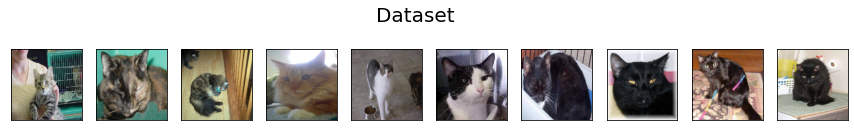

In [10]:
show_cat_data(data, title="Dataset")

#3- Preprocess 

Noise

In [11]:
# adds the gaussian noise based on the mean and the standard deviation 
def add_gaussian_noise(data):
  mean = (10, 10, 10)
  std = (50, 50, 50)
  row, col, channel = data.shape
  noise = np.random.normal(mean, std, (row, col, channel)).astype('uint8')
  return data + noise


def add_gaussian_to_dataset(data):
    count = 0
    end = len(data)
    output_data = []
    while count < end:
        output_data.append(add_gaussian_noise(data[count]))
        count+=1
    return np.array(output_data)

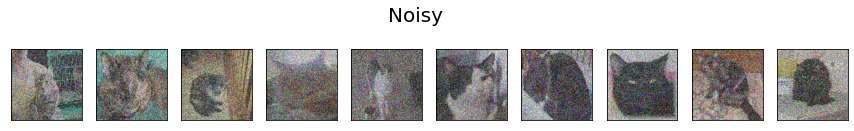

In [8]:
show_cat_data(add_gaussian_to_dataset(data), title="Noisy")

In [26]:
tf.keras.backend.clear_session()

In [10]:
train_data = data[:500]
test_data = data[3000:3100]

In [12]:
gaussian_train_data = add_gaussian_to_dataset(train_data)
gaussian_test_data = add_gaussian_to_dataset(test_data)

In [13]:
train_data = train_data / 255.0
test_data = test_data / 255.0
# reduce images
gaussian_train_data = gaussian_train_data / 255.0 
gaussian_test_data = gaussian_test_data / 255.0 

print(gaussian_train_data.shape)
print(gaussian_test_data.shape)

(500, 300, 300, 3)
(100, 300, 300, 3)


#4- Construct the autoencoder model

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [15]:
def create_model():
  x = Input(shape=(300, 300, 3)) 

  # Encoder
  e_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  pool1 = MaxPooling2D((2, 2), padding='same')(e_conv1)
  batchnorm_1 = BatchNormalization()(pool1)
  e_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
  pool2 = MaxPooling2D((2, 2), padding='same')(e_conv2)
  batchnorm_2 = BatchNormalization()(pool2)
  e_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
  h = MaxPooling2D((2, 2), padding='same')(e_conv3)


  # Decoder
  d_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
  up1 = UpSampling2D((2, 2))(d_conv1)
  d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
  up2 = UpSampling2D((2, 2))(d_conv2)
  d_conv3 = Conv2D(16, (3, 3), activation='relu')(up2)
  up3 = UpSampling2D((2, 2))(d_conv3)
  r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

  model = Model(x, r)
  model.compile(optimizer='adam', loss='mse')
  return model

In [16]:
gaussian_auto_encoder = create_model()
gaussian_early_stop = EarlyStopping(monitor='loss', patience=3)
gaussian_history = gaussian_auto_encoder.fit(gaussian_train_data, train_data, epochs=15, batch_size=32, callbacks=[gaussian_early_stop])

Epoch 1/15
16/16 [==============================] - 15s 281ms/step - loss: 0.0347
Epoch 2/15
16/16 [==============================] - 3s 185ms/step - loss: 0.0128
Epoch 3/15
16/16 [==============================] - 3s 187ms/step - loss: 0.0108
Epoch 4/15
16/16 [==============================] - 3s 187ms/step - loss: 0.0094
Epoch 5/15
16/16 [==============================] - 3s 189ms/step - loss: 0.0085
Epoch 6/15
16/16 [==============================] - 3s 187ms/step - loss: 0.0086
Epoch 7/15
16/16 [==============================] - 3s 189ms/step - loss: 0.0076
Epoch 8/15
16/16 [==============================] - 3s 188ms/step - loss: 0.0078
Epoch 9/15
16/16 [==============================] - 3s 190ms/step - loss: 0.0079
Epoch 10/15
16/16 [==============================] - 3s 188ms/step - loss: 0.0069
Epoch 11/15
16/16 [==============================] - 3s 189ms/step - loss: 0.0065
Epoch 12/15
16/16 [==============================] - 3s 194ms/step - loss: 0.0072
Epoch 13/15
16/16 [=====

In [33]:
 gaussian_auto_encoder.save('Mymodel_1.h5')
 files.download('Mymodel_1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

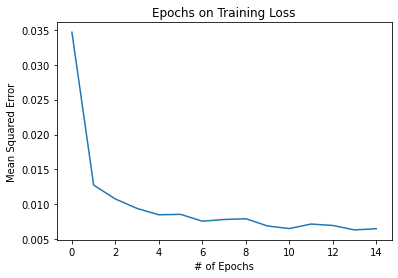

In [17]:
plt.plot(gaussian_history.epoch, gaussian_history.history['loss'])
plt.title('Epochs on Training Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

In [18]:
result = gaussian_auto_encoder.predict(gaussian_test_data)
gaussian_auto_encoder.evaluate(test_data, gaussian_test_data)

4/4 [==============================] - 0s 46ms/step - loss: 0.4968


0.49684566259384155

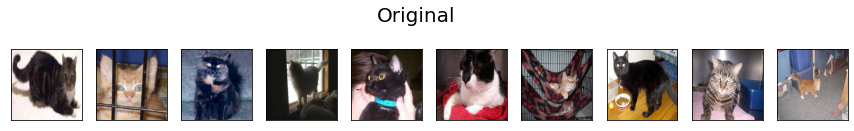

In [28]:
show_cat_data(test_data, title="Original")

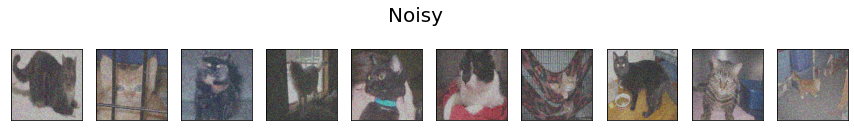

In [29]:
show_cat_data(gaussian_test_data, title="Noisy")

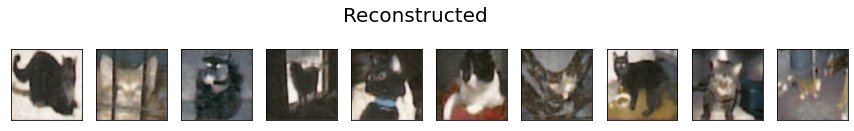

In [25]:
show_cat_data(result, title="Reconstructed")

In [1]:
test_path="../content/custom/"
custom = []
for filename in os.listdir(test_path):
    if filename.endswith(".jpg"):
        img = image.load_img(test_path + filename, target_size=(300, 300))
        custom.append(image.img_to_array(img))
custom = np.array(custom)

In [8]:
def show_custom_data(X, n=3, title=""):
    plt.figure(figsize=(15, 4))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

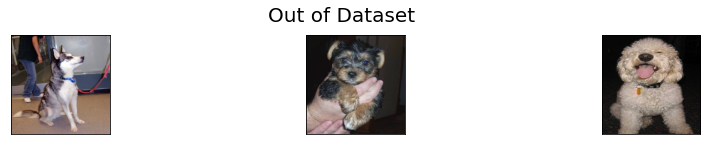

In [9]:
show_custom_data(custom, title="Out of Dataset")

In [12]:
cutom_gaussian_test_data = add_gaussian_to_dataset(custom)

In [13]:
cutom_gaussian_test_data = cutom_gaussian_test_data / 255.0 

In [14]:
from keras.models import load_model
test_model = load_model('Mymodel_1.h5')

In [15]:
test_model.compile(optimizer='adam', loss='mse')

In [21]:
test_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0     

In [16]:
result = test_model.predict(cutom_gaussian_test_data)

1/1 [==============================] - 8s 8s/step


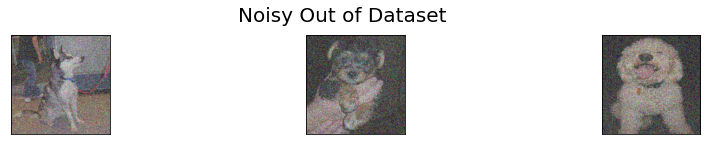

In [19]:
show_custom_data(cutom_gaussian_test_data, title="Noisy Out of Dataset")

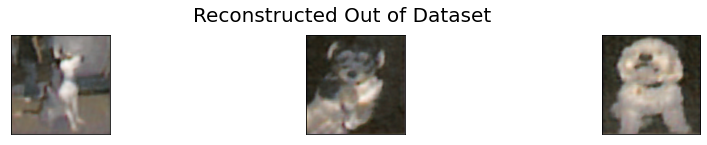

In [18]:
show_custom_data(result, title="Reconstructed Out of Dataset")